# Imports

In [1]:
# filtering messages to error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# python imports
from timeit import default_timer as timer
from time import gmtime, strftime

#third-party imports
import numpy as np

from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from matplotlib import pyplot as plt
%matplotlib inline

# project imports
from utils.al import active_learn_loop
from utils.data import load_data
from utils.data import initial_query_test_split

# Loading Data

In [3]:
X_unlabeled, _ = load_data('datasets/vulns-unlabeled.csv')
X_labeled, y_labeled = load_data('datasets/vulns-labeled.csv')

# Pipeline

In [4]:
def run_pipeline(active_model, super_model, 
                 X_unlabeled, X, y, initial_size, test_size, 
                 n_queries, n_interactions, 
                 scale_active_data, scale_super_data):
    
    acc_active_list = list()
    acc_super_list = list()
    elapsed_list = list()

    print(f'\n# {str(active_model)} + {str(super_model)}\n')

    for i in range(n_interactions):

        # Splitting data
        # --------------

        X_initial, X_query, X_test, y_initial, y_query, y_test =\
            initial_query_test_split(X, y, initial_size, test_size)
        
        # Active learning
        # ---------------
        
        # scaling data if necessary
        scaler = None
        if scale_active_data:
            scaler = StandardScaler().fit(X_query)
        
            X_initial = scaler.transform(X_initial)
            X_query = scaler.transform(X_query)
            X_test = scaler.transform(X_test)
        
        # active learner loop
        learner_active, t_active_learn, X_train, y_train =\
            active_learn_loop(active_model, X_initial, y_initial, X_query, y_query, n_queries)
        
        score = learner_active.score(X_test, y_test)
        acc_active_list.append(score)
        
        # denormalize data if necessary
        if scale_active_data:
            X_train = scaler.inverse_transform(X_train)
            X_test = scaler.inverse_transform(X_test)

        # Supervised learning
        # ------------------------
        
        # scalling data if necessary
        if scale_super_data:
            scaler = StandardScaler().fit(X_train)
            
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
        t_semi_learn = timer()

        learner_semi = SelfTrainingClassifier(base_estimator=super_model, threshold=0.99)
        learner_semi.fit(X_train, y_train)

        t_semi_learn = timer() - t_semi_learn
        
        score = learner_semi.score(X_test, y_test)

        acc_super_list.append(score)
        
        # Calculating elapsed time
        # ------------------------
        
        elapsed = t_active_learn + t_semi_learn
        elapsed_list.append(elapsed)

    # Printing statistics
    # -------------------
    
    print(f' - Avg. Active learning accuracy: {np.mean(acc_active_list):.2f}')
    print(f' - Avg. Semi-supervised learning accuracy: {np.mean(acc_super_list):.2f}\n')
    print(f' - Avg. time: {strftime("%H:%M:%S", gmtime(np.mean(elapsed_list)))}\n')
    print(f' - Confusion matrix:')
    ConfusionMatrixDisplay.from_estimator(learner_semi, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

# Runs


# GradientBoostingClassifier() + GradientBoostingClassifier()

 - Avg. Active learning accuracy: 0.72
 - Avg. Semi-supervised learning accuracy: 0.65

 - Avg. time: 00:00:15

 - Confusion matrix:


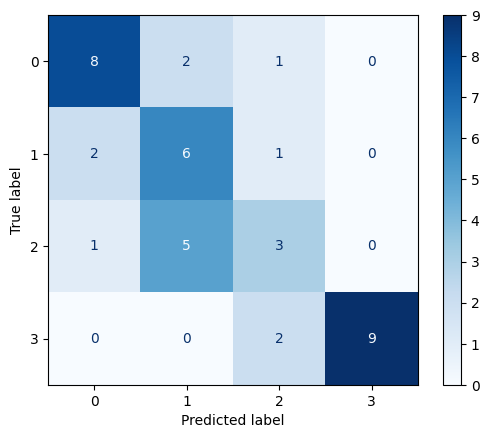

In [5]:
run_pipeline(GradientBoostingClassifier(), GradientBoostingClassifier(),
             X_unlabeled, X_labeled, y_labeled, initial_size=20, test_size=40,
             n_queries=80, n_interactions=1,
             scale_active_data=False, scale_super_data=False)